# Promoter footprints with Mutual Information and Linear Regression

In [95]:
#import mavenn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.linear_model import LinearRegression
from os.path import exists
import seaborn as sns
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable

sns.set()

from sklearn.decomposition import FastICA

Import mapped sequencing data to obtain all promoter names.

In [2]:
df_mapped = pd.read_csv("../../../data/barcodes/20220514_mapping/mapped_barcodes.csv", delim_whitespace=True)

In [3]:
promoter_names = df_mapped.name.unique()
def find_promoter(name):
    ind = [name in x for x in promoter_names]
    return promoter_names[ind][0]

In [176]:
color_dict={
    "act":"#BFD598",
    "dual":"#F3DAA9",
    "rep":"#E8B19D",
    "pol":"#A9BFE3"
   }

## Expression shift

In [218]:
def expression_shift(promoter, sites, d=1):
    """
    Plot promoter footprint and add annotations for annotated sites.
    """
    X = []
    # Iterate through growth conditions
    for gc in ["LB", "Etoh", "Gluc", "XyAr"]:
        
        # Double check that the files for the promoter exist
        filepath = "../../../data/processed_barcodes/20221114_barcode/{}_by_promoter/{}_counts.csv".format(gc, promoter)
        if not exists(filepath):
            break
        df = pd.read_csv(filepath)
        df["relative_counts"] = df.cDNA_count / df.gDNA_count
        df["total_counts"] = df.cDNA_count + df.gDNA_count
        
        # transform sequences to integers
        DNA_dict = {"A":0, "C":1, "G":2, "T":3}
        def make_int(x):
            return np.array([DNA_dict[y] for y in x])

        df['int_promoter'] = df['promoter'].apply(make_int)
        
        # compute nucleotide frequencies
        freq_mat = np.zeros([2, 4, 160])
        for gDNA_counts, cDNA_counts, prom in zip(df['gDNA_count'], df['cDNA_count'], df['int_promoter']):
            freq_mat[0, prom, np.arange(160)] += gDNA_counts
            freq_mat[1, prom, np.arange(160)] += cDNA_counts
            
        freq_mat /= np.sum(df.total_counts)
        
        # find wild type sequence 
        wt_seq = np.argmax(np.sum(freq_mat, axis=0), axis=0)
        
        def is_mut(x):
            return ~np.equal(x, wt_seq)
        
        df['is_mutated'] = df['int_promoter'].apply(is_mut)
        
        mean_rel_counts = np.mean(df["relative_counts"])
        tot_counts = np.sum(df["total_counts"])
        
        ex_shift_arr = np.zeros(160)
        for x, seq, c in zip(df['relative_counts'], df['is_mutated'], df['total_counts']):
            ex_shift_arr[seq] += (x - mean_rel_counts) #* -1/np.log(c / tot_counts)
        
        # make plot
        fig, ax = plt.subplots(1, 1, figsize=(15, 4), sharex=True)
        
        # colors for plotting (from PBoC)
        color_dict={
            "act":"#BFD598",
            "dual":"#F3DAA9",
            "rep":"#E8B19D",
            "pol":"#A9BFE3"
           }
        
        # compute rolling average for expression shift
        ex_shift_av = [np.sum(ex_shift_arr[i-d:i+d]) / (2 * d + 1) for i in range(d, 160-d)]
        ex_shift_colors = [color_dict["rep"] if x > 0 else color_dict["act"] for x in ex_shift_av]
        
        # plot expression shift
        ax.bar(np.arange(160 - 2 * d) - (115-d), ex_shift_av, color=ex_shift_colors)
        ax.set_ylabel("Expression Shift")
        ax.set_title(promoter + " in " + gc)
        
        # plot patches
        for element in sites:
            if element[2] == "act":
                h = 1.15 * np.min(ex_shift_av)
            else:
                h = 1.15 * np.max(ex_shift_av)
            pp1 = Rectangle(
                (element[0], 0), 
                -(element[0] - element[1]), 
                h, 
                alpha=0.2, 
                edgecolor="black", 
                facecolor=color_dict[element[2]]
            )
            ax.add_patch(pp1)
            ax.annotate(element[3], (element[0], h)) 

        plt.subplots_adjust(wspace=0, hspace=0)
        X.append(ex_shift_arr)
    
    transformer = FastICA(
        n_components=len(X),
        whiten="arbitrary-variance",
        max_iter=2000
        )
    X_transformed = transformer.fit_transform(np.array(X).T)
    fig, ax = plt.subplots(1, 1, figsize=(14, 4))
    ax.set_title("ICA")
    ax.set_ylabel("Signals")
    
    for i in range(len(X)):
        x = X[i]
        y = [np.mean(x[i-d:i+d]) for i in np.arange(d, 160-d)]
        ax.plot(np.arange(-115+d, 45-d), y)
    
    ax.plot(np.arange(-115+d, 45-d), [np.mean(np.mean(X, axis=0)[i-d:i+d]) for i in range(d, 160-d)], linewidth=4, color="white")
        
    for element in sites:
            if element[2] == "act":
                h = 1.15 * np.min(ex_shift_av)
            else:
                h = 1.15 * np.max(ex_shift_av)
            pp1 = Rectangle(
                (element[0], 0), 
                -(element[0] - element[1]), 
                h, 
                alpha=0.2, 
                edgecolor="black", 
                facecolor=color_dict[element[2]]
            )
            ax.add_patch(pp1)
            ax.annotate(element[3], (element[0], h)) 
    plt.tight_layout()     
    return

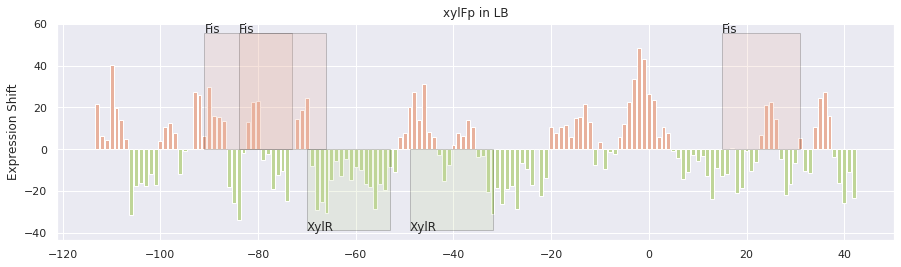

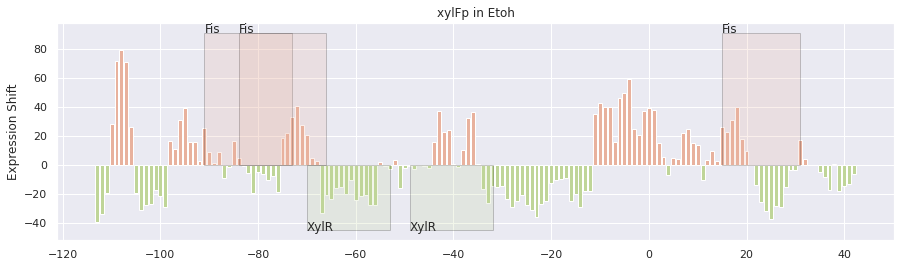

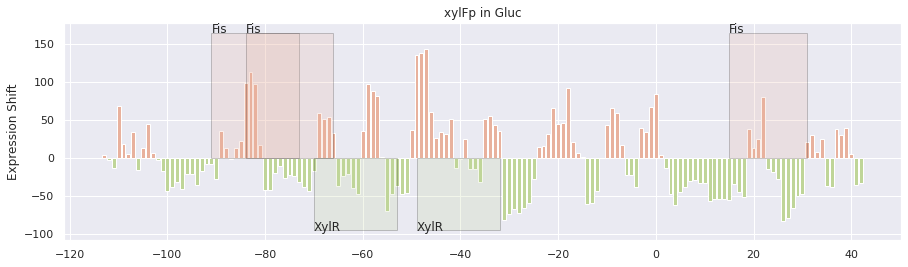

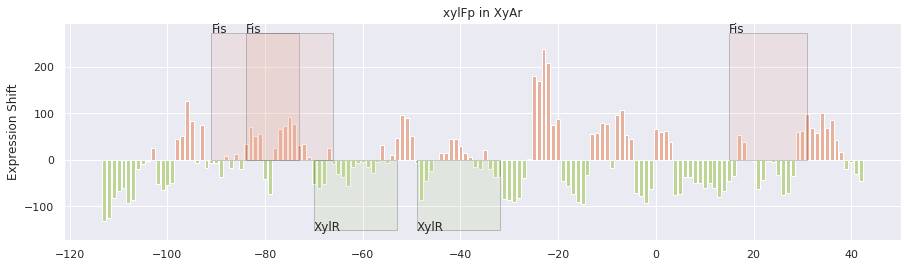

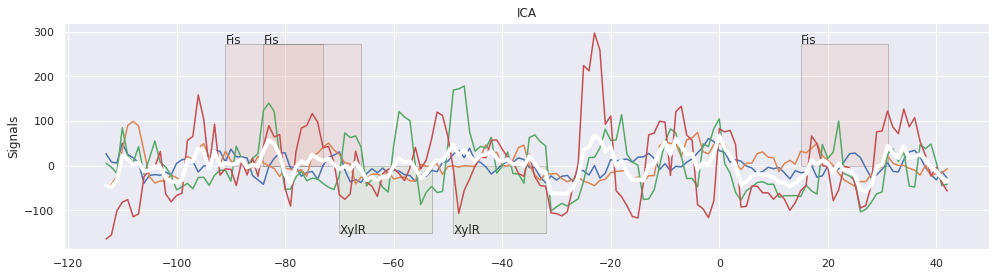

In [415]:
promoter = "xylFp"

sites = [
    (-91, -73, "rep", "Fis"),
    (-84, -66, "rep", "Fis"),
    (-70, -53, "act", "XylR"),
    (-49, -32, "act", "XylR"),
    (15, 31, "rep", "Fis"),
]

expression_shift(promoter, sites, d=2)

/home/tom/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


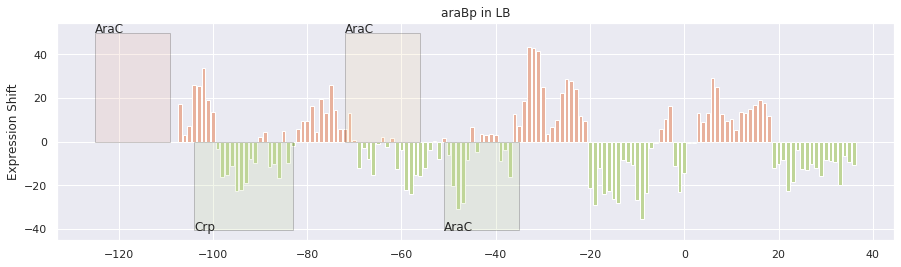

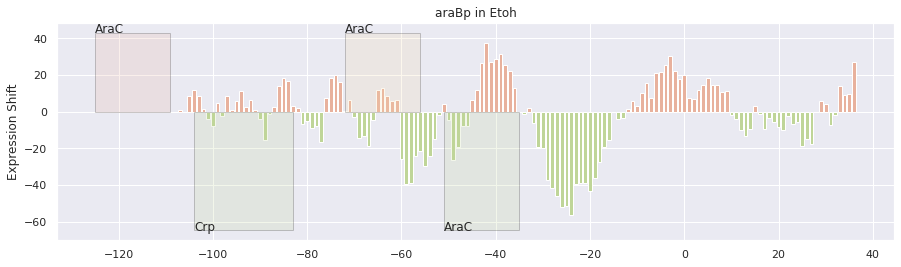

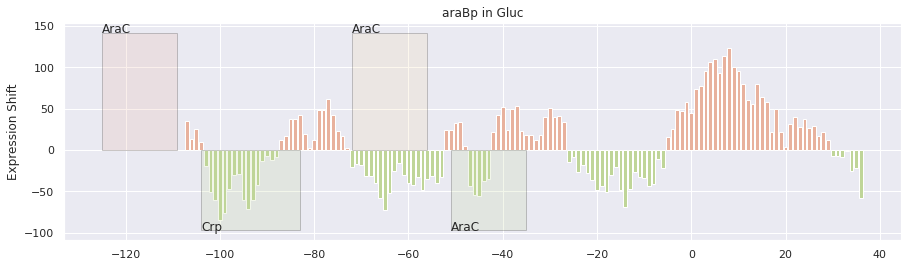

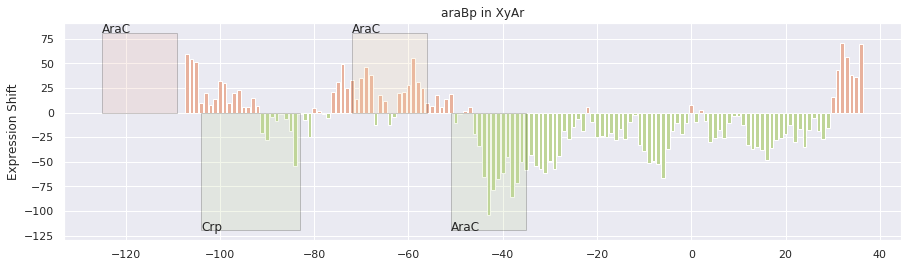

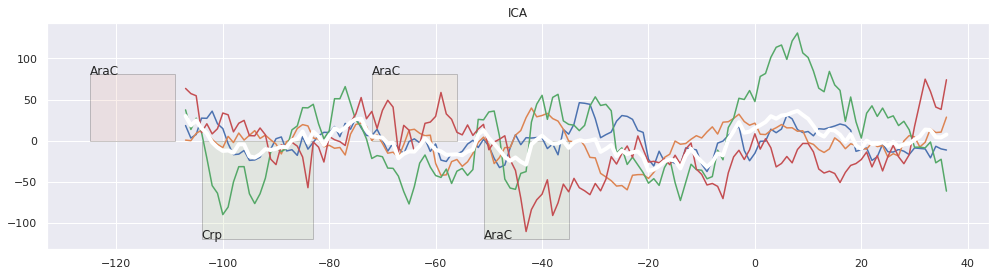

In [410]:
promoter = "araBp"

sites = [
    (-125, -109, "rep", "AraC"),
    (-104, -83, "act", "Crp"),
    (-72, -56, "dual", "AraC"),
    (-51, -35, "act", "AraC"),
]

expression_shift(promoter, sites, d=8)

/home/tom/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


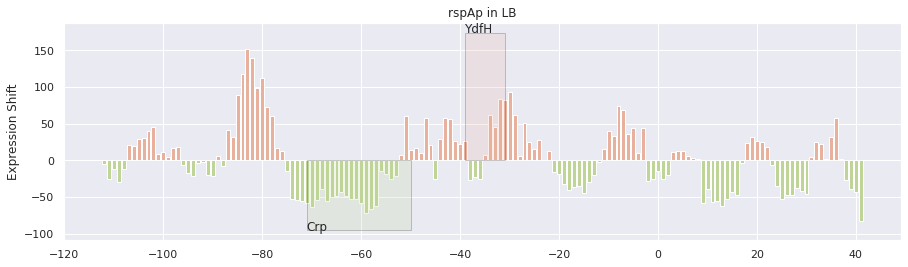

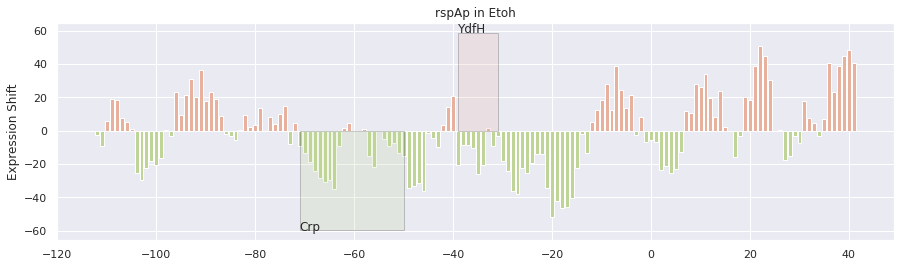

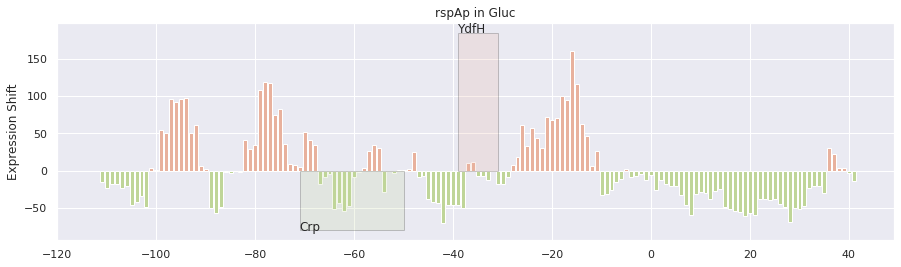

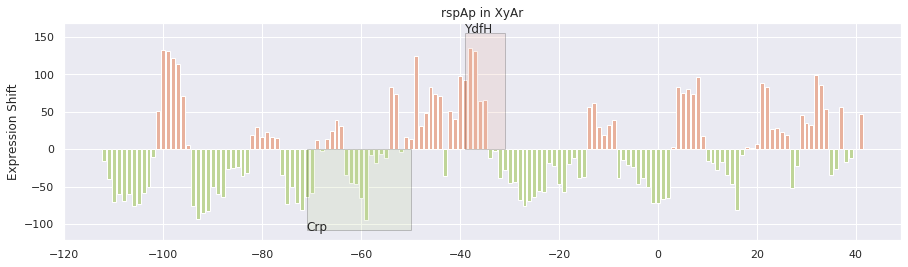

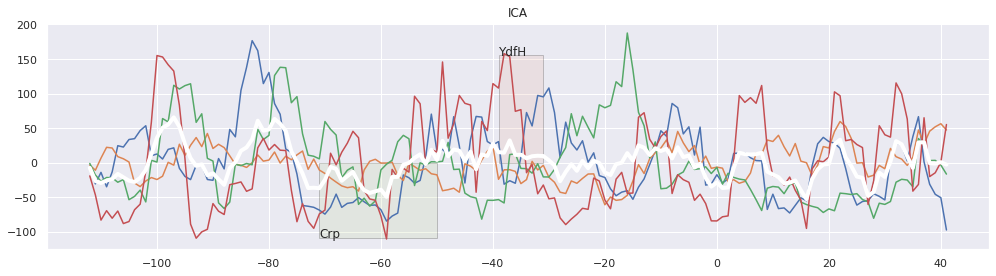

In [411]:
promoter = "rspAp"

sites = [
    (-39, -31, "rep", "YdfH"),
    (-71, -50, "act", "Crp"),
]
expression_shift(promoter, sites, d=3)

### Synthetic data

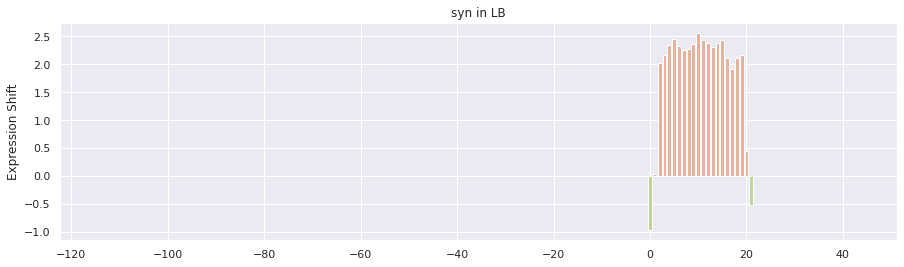

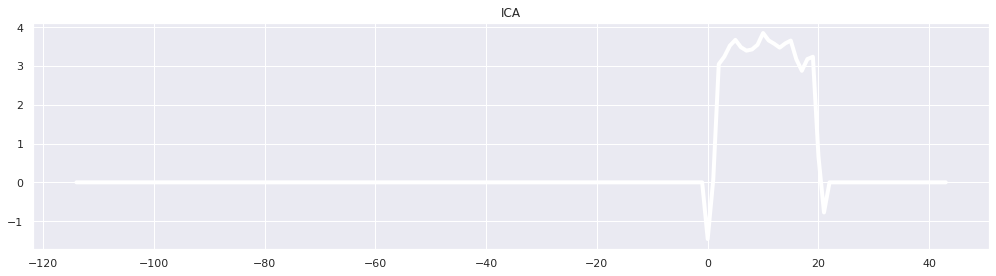

In [412]:
promoter = "syn"

sites = []

expression_shift(promoter, sites, d=1)

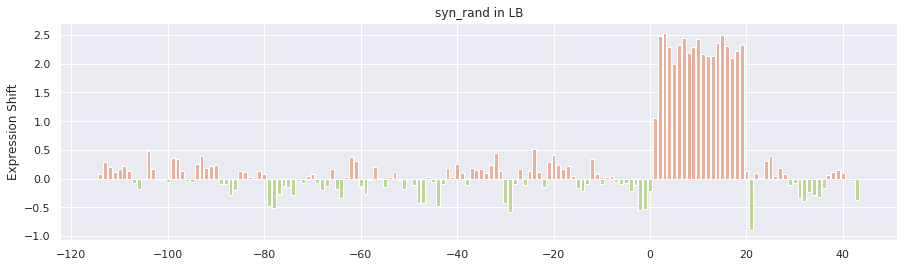

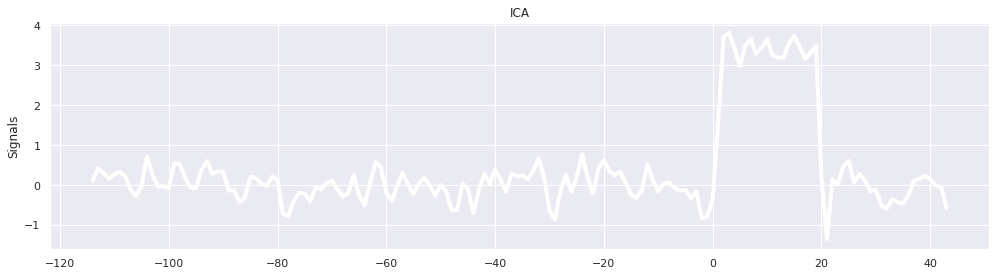

In [219]:
promoter = "syn_rand"

sites = []

expression_shift(promoter, sites, d=1)

# Frequency matrices

In [173]:
def freq_mat(promoter, gc, sites, d=1):
    filepath = "../../../data/processed_barcodes/20221114_barcode/{}_by_promoter/{}_counts.csv".format(gc, promoter)
    if not exists(filepath):
        return
    df = pd.read_csv(filepath)
    df["relative_counts"] = df.cDNA_count / df.gDNA_count
    df["total_counts"] = df.cDNA_count + df.gDNA_count

    # transform sequences to integers
    DNA_dict = {"A":0, "C":1, "G":2, "T":3}
    def make_int(x):
        return np.array([DNA_dict[y] for y in x])

    df['int_promoter'] = df['promoter'].apply(make_int)
    # compute nucleotide frequencies
    freq_mat = np.zeros([2, 4, 160])
    tot_gDNA = np.sum(df['gDNA_count'])
    tot_cDNA = np.sum(df['cDNA_count'])
    for gDNA_counts, cDNA_counts, prom in zip(df['gDNA_count'], df['cDNA_count'], df['int_promoter']):
        freq_mat[0, prom, np.arange(160)] += gDNA_counts / tot_gDNA
        freq_mat[1, prom, np.arange(160)] += cDNA_counts / tot_cDNA
    
    # find wild type sequence 
    wt_seq = np.argmax(np.sum(freq_mat, axis=0), axis=0)
    
    freq_diffs = (freq_mat[0, :, :] - freq_mat[1, :, :])
    
    fig, ax = plt.subplots(3, 1, figsize=(15,8))
    
    ax[0].set_title("Differences at each position in frequencies.")
    ax[0].set_yticks([0, 1, 2, 3], ["A", "C", "G", "T"])
    ax[0].set_xticks([])
    ax[1].set_title("Differences at each position in frequencies.")
    ax[2].set_title("Differences in occurence of wild type letter between RNA and DNA.")
    ax[2].set_xlabel("Position")
    
    z1_plot = ax[0].imshow(
        freq_diffs, 
        aspect="auto", 
        cmap="bwr", 
        vmin=-np.max(np.abs(freq_diffs)), 
        vmax=np.max(np.abs(freq_diffs))
    )
    
    ax[0].grid(False)
    divider = make_axes_locatable(ax[0])

    ax_cb = divider.append_axes("right", size="2%", pad=0.05)
    fig_ = ax[0].get_figure()
    fig_.add_axes(ax_cb)

    plt.colorbar(z1_plot, cax=ax_cb)
    y = np.sum(np.abs(freq_diffs), axis=0)
    ax[1].bar(np.arange(d, 160-d) - 115, [np.sum(y[i-d:i+d+1]) / (2 * d + 1) for i in range(d, 160-d)])
    diff_av = [np.sum(freq_diffs[wt_seq, np.arange(160)][i-d:i+d+1]) / (2 * d + 1) for i in range(d, 160-d)]
    ax[2].bar(np.arange(d, 160-d) - 115, diff_av)
    
    for element in sites:
        if element[2] == "act":
            h = 1.15 * np.min(diff_av)
        else:
            h = 1.15 * np.max(diff_av)
        pp1 = Rectangle(
            (element[0], 0), 
            -(element[0] - element[1]), 
            h, 
            alpha=0.2, 
            edgecolor="black", 
            facecolor=color_dict[element[2]]
        )
        ax[2].add_patch(pp1)
        ax[2].annotate(element[3], (element[0], h)) 
    
    plt.tight_layout()
    return 

/tmp/ipykernel_13159/2391114904.py:52: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(z1_plot, cax=ax_cb)


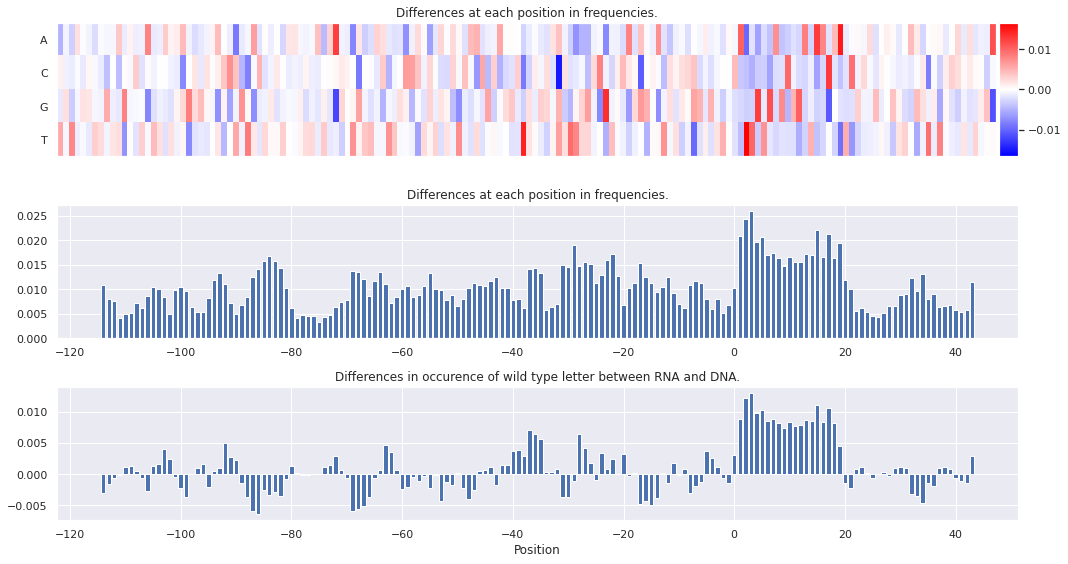

In [215]:
promoter = "syn_rand"
sites=[]
freq_mat(promoter, "LB", sites, d=1)

/tmp/ipykernel_13159/2391114904.py:52: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(z1_plot, cax=ax_cb)


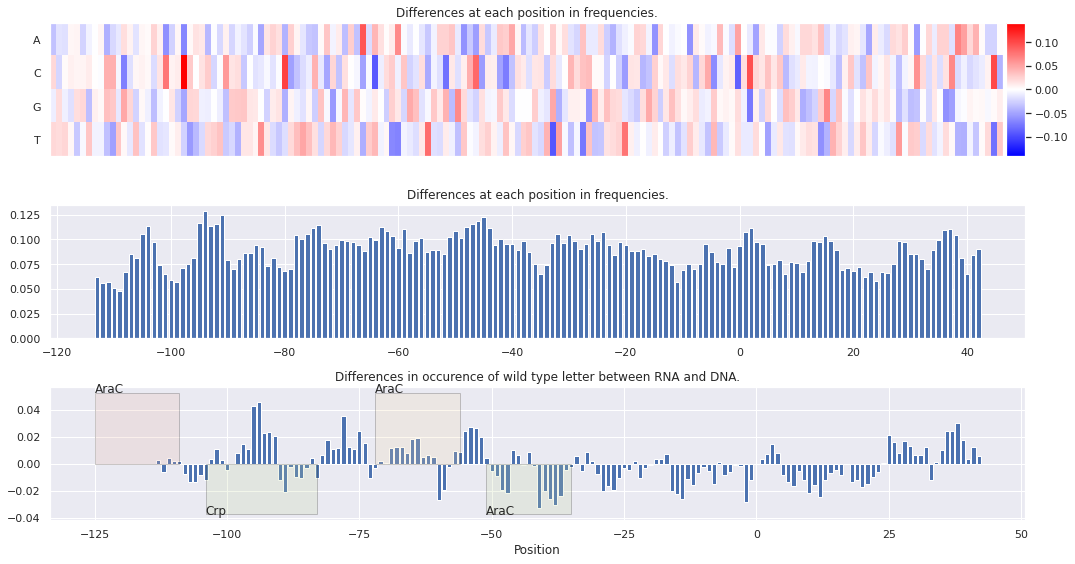

In [209]:
promoter = "araBp"

sites = [
    (-125, -109, "rep", "AraC"),
    (-104, -83, "act", "Crp"),
    (-72, -56, "dual", "AraC"),
    (-51, -35, "act", "AraC"),
]

freq_mat(promoter, "XyAr", sites, d=2)

/tmp/ipykernel_13159/2391114904.py:52: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(z1_plot, cax=ax_cb)


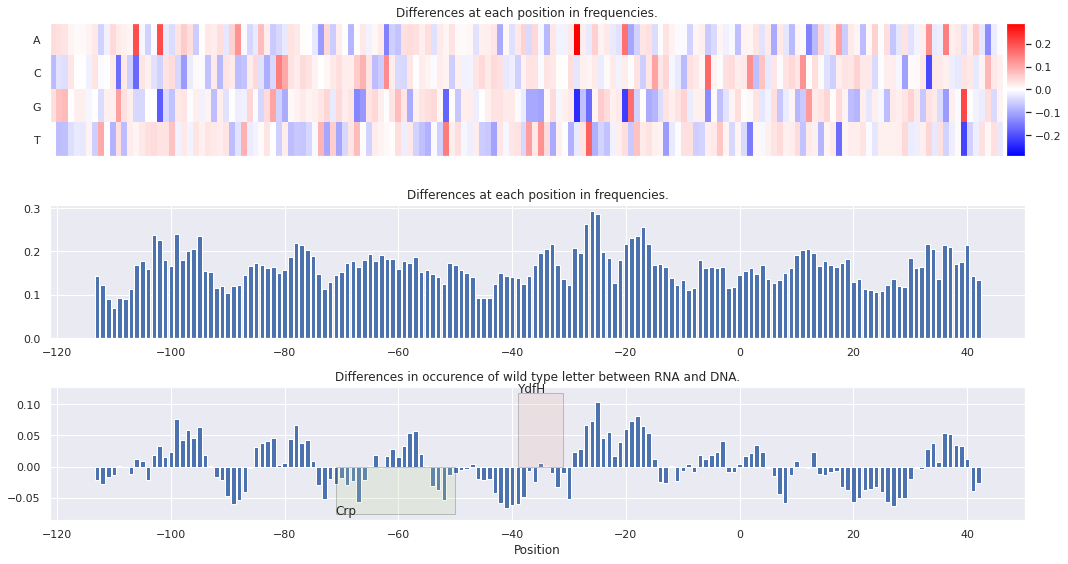

In [184]:
promoter = "rspAp"

sites = [
    (-39, -31, "rep", "YdfH"),
    (-71, -50, "act", "Crp"),
]

freq_mat(promoter, "Gluc", sites, d=2)

/tmp/ipykernel_13159/2391114904.py:52: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(z1_plot, cax=ax_cb)


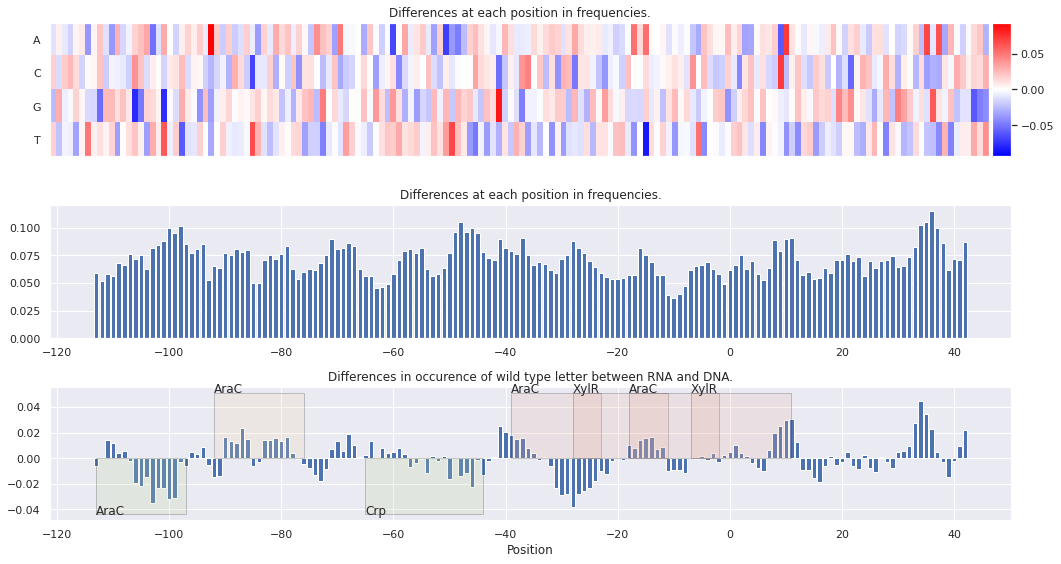

In [187]:
promoter = "araCp"

sites = [
    (-113, -97, "act", "AraC"),
    (-92, -76, "dual", "AraC"),
    (-65, -44, "act", "Crp"),
    (-39, -23, "rep", "AraC"),
    (-28, -11, "rep", "XylR"),
    (-18, -2, "rep", "AraC"),
    (-7, 11, "rep", "XylR"),
]

freq_mat(promoter, "Gluc", sites, d=2)

/tmp/ipykernel_13159/2391114904.py:52: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(z1_plot, cax=ax_cb)


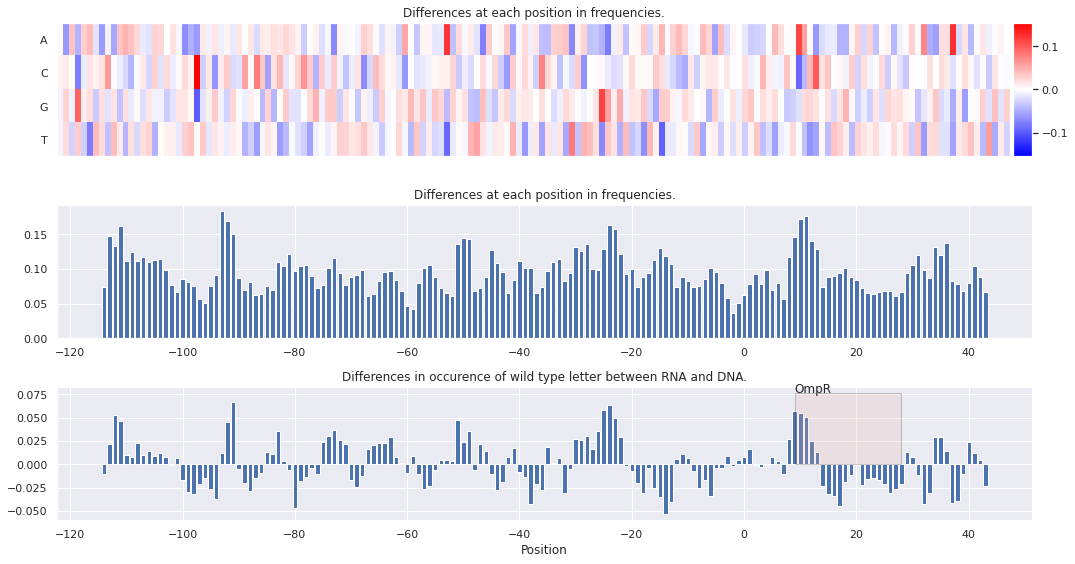

In [191]:
promoter = find_promoter("ecnB")

sites = [
    (9, 28, "rep", "OmpR"),
]
freq_mat(promoter, "Etoh", sites, d=1)

## ICA

In [ ]:
transformer = FastICA(
    n_components=7,
    random_state=0,
    whiten='unit-variance')
X_transformed = transformer.fit_transform(X)
X_transformed.shape

## Mutual information and Linear Regression

In [220]:
def mut_information(p):
    """
    Compute mutial information from joint probability distribution p(m, mu).
    """
    l = np.size(p, 2)
    I = np.zeros(l)
    for i in range(l):
        p_mu = np.sum(p[:, :, i], axis=0)
        p_m = np.sum(p[:, :, i], axis=1)
        I[i] = np.sum([p[m, mu, i] * np.log2(p[m, mu, i] / p_m[m] / p_mu[mu]) for mu in [0, 1] for m in [0, 1]])

    return I

    

def make_footprints(promoter, sites, d_lin=2, d_MI=2):
    """
    Plot promoter footprint and add annotations for annotated sites.
    """
    
    # Iterate through growth conditions
    for gc in ["LB", "Etoh", "Gluc", "XyAr"]:
        
        # Double check that the files for the promoter exist
        filepath = "../../../data/processed_barcodes/20221114_barcode/{}_by_promoter/{}_counts.csv".format(gc, promoter)
        if not exists(filepath):
            break
        df = pd.read_csv(filepath)
        
        # read counts and compute total counts per sequence
        df["total_counts"] = [x + y for x, y in zip(df.cDNA_count, df.gDNA_count)]
    
        # transform sequences to integers
        DNA_dict = {"A":0, "C":1, "G":2, "T":3}
        def make_int(x):
            return np.array([DNA_dict[y] for y in x])

        df['int_promoter'] = df['promoter'].apply(make_int)
        
        # compute nucleotide frequencies
        freq_mat = np.zeros([2, 4, 160])
        for gDNA_counts, cDNA_counts, prom in zip(df['gDNA_count'], df['cDNA_count'], df['int_promoter']):
            freq_mat[0, prom, np.arange(160)] += gDNA_counts
            freq_mat[1, prom, np.arange(160)] += cDNA_counts
            
        freq_mat /= np.sum(df.total_counts)
        
        # find wild type sequence 
        wt_seq = np.argmax(np.sum(freq_mat, axis=0), axis=0)
        
        # compute relative counts and rescale by mean
        rel_counts = df.cDNA_count / df.gDNA_count
        rel_counts = rel_counts - np.mean(rel_counts)
        
        # make binary sequences about mutations
        binary_seqs = [1 - np.equal(wt_seq, x) for x in df['int_promoter']]
        reg = LinearRegression().fit(binary_seqs, rel_counts)
        
        
        # compute probabilites for mutual information
        p = np.zeros([2, 2, 160])
        p[0, 0, :] = np.max(freq_mat[0, :, :], axis=0)
        p[1, 0, :] = np.sum(freq_mat[0, :, :], axis=0) - np.max(freq_mat[0, :, :], axis=0)
        p[0, 1, :] = np.max(freq_mat[1, :, :], axis=0)
        p[1, 1, :] = np.sum(freq_mat[1, :, :], axis=0) - np.max(freq_mat[1, :, :], axis=0)
        
        # compute mutual information
        MI = mut_information(p)
        
        # make plot
        fig, ax = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
        
        # colors for plotting (from PBoC)
        color_dict={
            "act":"#BFD598",
            "dual":"#F3DAA9",
            "rep":"#E8B19D",
            "pol":"#A9BFE3"
           }
        
        # compute rolling average for linear regression
        lin_reg_av = [np.sum(reg.coef_[i-d_lin:i+d_lin]) / (2 * d_lin + 1) for i in range(d_lin, 160-d_lin)]
        lin_reg_colors = [color_dict["rep"] if x > 0 else color_dict["act"] for x in lin_reg_av]
        
        # plot linear regression
        ax[0].bar(np.arange(160 - 2 * d_lin) - (115-d_lin), lin_reg_av, color=lin_reg_colors)
        ax[0].set_ylabel("Linear Regression Coefficient")
        ax[0].set_title(promoter + " in " + gc)
            
        # compute rolling average for mutual information
        MI_av = [np.sum(MI[i-d_MI:i+d_MI]) / (2 * d_MI + 1) for i in range(d_MI, 160-d_MI)]

        # plot mutual information footprint
        ax[1].bar(np.arange(160 - 2 * d_MI) - (115-d_MI), MI_av)
        ax[1].set_ylabel("Mutual Information")
        ax[1].set_xlabel("Position [rel. to TSS]")

        # plot patches
        for element in sites:
            if element[2] == "act":
                h = 1.15 * np.min(lin_reg_av)
            else:
                h = 1.15 * np.max(lin_reg_av)
            pp1 = Rectangle(
                (element[0], 0), 
                -(element[0] - element[1]), 
                h, 
                alpha=0.2, 
                edgecolor="black", 
                facecolor=color_dict[element[2]]
            )
            ax[0].add_patch(pp1)
            ax[0].annotate(element[3], (element[0], h)) 
            
            if element[2] == "pol":
                h = 1.15 * np.max(MI_av)
            else:
                h = 1.05 * np.max(MI_av)
            
            pp1 = Rectangle(
                (element[0], 0), 
                -(element[0] - element[1]), 
                h, 
                alpha=0.2, 
                edgecolor="black", 
                facecolor=color_dict[element[2]]
            )
                
            ax[1].add_patch(pp1)
            ax[1].annotate(element[3], (element[0], h)) 
        plt.subplots_adjust(wspace=0, hspace=0)
        if len(sites) == 0:
            continue
            #fig.savefig("../../../code/processing/20221114_barcode/figures/footprints_unannotated/{}_footprint_{}.pdf".format(promoter,gc))
        else:
            continue
            #fig.savefig("../../../code/processing/20221114_barcode/figures/footprints_annotated/{}_footprint_{}.pdf".format(promoter,gc))
        
        #plt.close(fig)

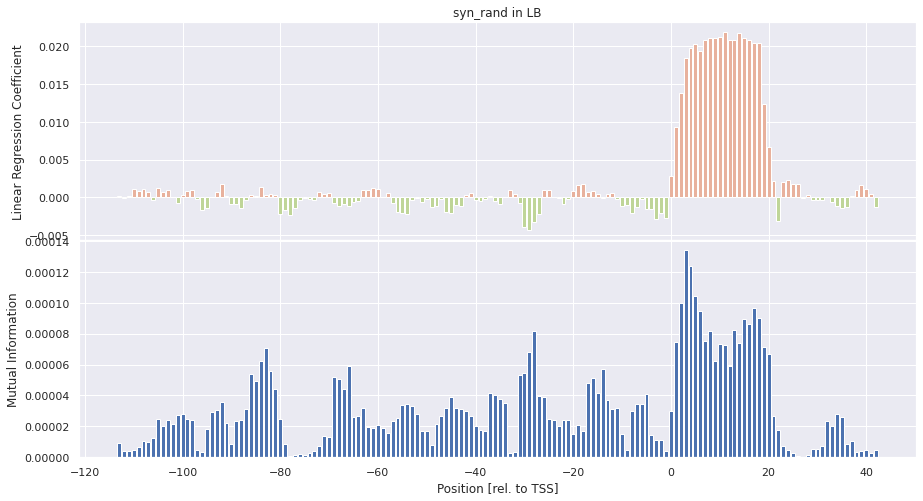

In [221]:
promoter = "syn_rand"
sites=[]

make_footprints(promoter, sites)

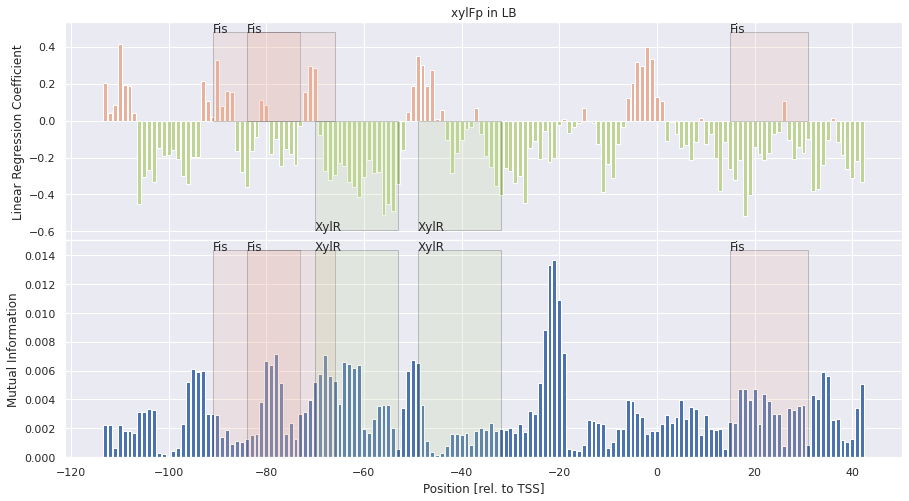

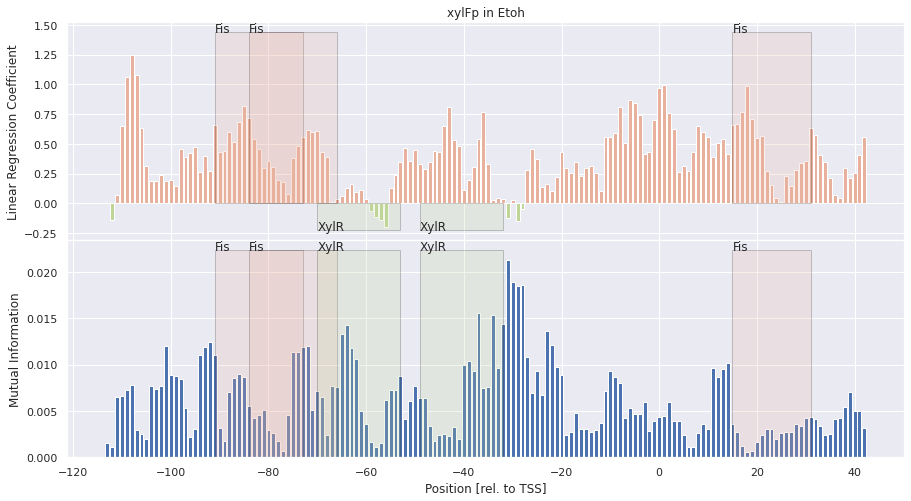

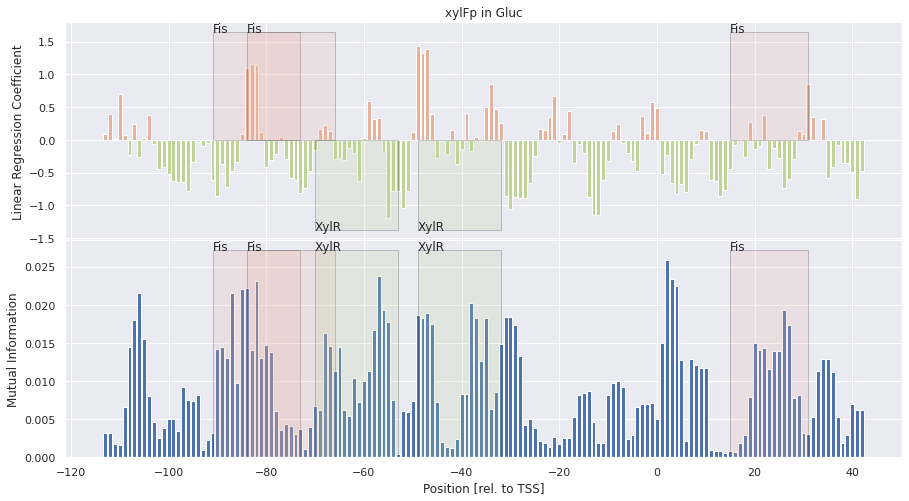

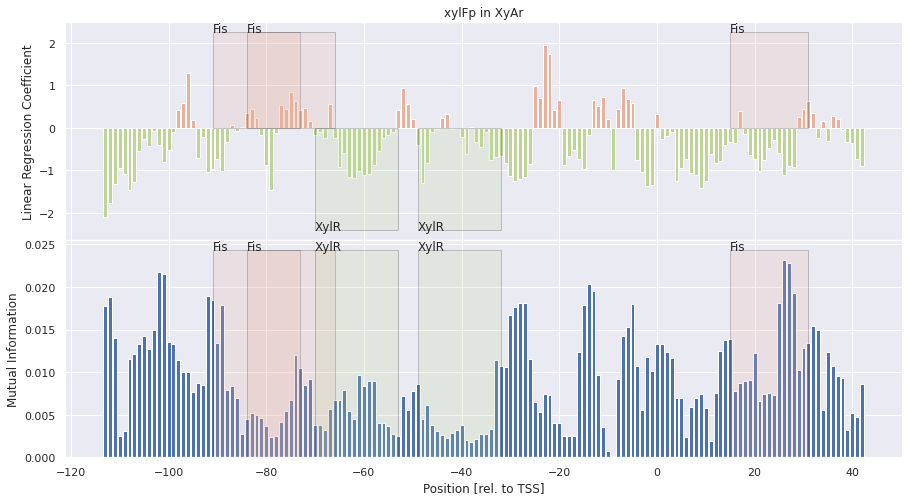

In [197]:
promoter = "xylFp"

sites = [
    (-91, -73, "rep", "Fis"),
    (-84, -66, "rep", "Fis"),
    (-70, -53, "act", "XylR"),
    (-49, -32, "act", "XylR"),
    (15, 31, "rep", "Fis"),
]

make_footprints(promoter, sites)

In [ ]:
promoter = "araBp"

sites = [
    (-125, -109, "rep", "AraC"),
    (-104, -83, "act", "Crp"),
    (-72, -56, "dual", "AraC"),
    (-51, -35, "act", "AraC"),
]

make_footprints(promoter, sites)

In [ ]:
promoter = "araCp"

sites = [
    (-113, -97, "act", "AraC"),
    (-92, -76, "dual", "AraC"),
    (-65, -44, "act", "Crp"),
    (-39, -23, "rep", "AraC"),
    (-28, -11, "rep", "XylR"),
    (-18, -2, "rep", "AraC"),
    (-7, 11, "rep", "XylR"),
]

make_footprints(promoter, sites)

In [ ]:
promoter = "rspAp"

sites = [
    (-39, -31, "rep", "YdfH"),
    (-71, -50, "act", "Crp"),
]
make_footprints(promoter, sites)

In [ ]:
promoter = "xylAp"

sites = [
    (-92, -71, "act", "Crp"),
    (-71, -54, "act", "XylR"),
    (-55, -40, "rep", "AraC"),
    (-50, -33, "act", "XylR"),
    (-33, -17, "rep", "AraC"),
]

make_footprints(promoter, sites)

In [ ]:
promoter = "yacCp"

sites = [
]
make_footprints(promoter, sites)

In [ ]:
promoter = find_promoter("yahL")
sites = [
]
make_footprints(promoter, sites)

In [ ]:
promoter = find_promoter("fur")
sites = [
]
make_footprints(promoter, sites)

In [ ]:
promoter = find_promoter("ybiY")
sites = [
]
make_footprints(promoter, sites)

In [ ]:
promoter = find_promoter("rcsB")
sites = [
]
make_footprints(promoter, sites)

In [ ]:
promoter = find_promoter("xdhA")
sites = [
]
make_footprints(promoter, sites)

In [ ]:
promoter = find_promoter("relB")
sites = [
    (-19, -8, "rep", "RelEB"),
    (-5, 7, "rep", "RelEB/RelE"),
    (8, 19, "rep", "RelEB/RelE"),
    (23, 33, "rep", "RelEB")
]
make_footprints(promoter, sites)

In [ ]:
promoter = find_promoter("ftsK")
sites = [
    (-10, 10, "rep", "LexA"),
]
make_footprints(promoter, sites)

In [ ]:
promoter = find_promoter("znuC")
sites = [
    (-36, -20, "act", "OxyR"),
    (-21, 2, "rep", "Zur")
]
make_footprints(promoter, sites)

In [ ]:

promoter = find_promoter("lacI")
sites = [
]
make_footprints(promoter, sites)

In [ ]:
promoter = find_promoter("galS")
sites = [
    (-69, -54, "rep", "galS/galE"),
    (-53, -32, "act", "Crp")
]
make_footprints(promoter, sites)

In [ ]:
promoter = find_promoter("cpxR")
sites = [
    (-57, -37, "act", "CpxR"),
    (-77, -57, "act", "CpxR")
]
make_footprints(promoter, sites)

In [ ]:
promoter = find_promoter("hdeA")
sites = [
    (-20, -35, "rep", "FliZ"),
    (-1, 19, "act", "GadE"),
    (-25, -11, "rep", "Lrp"),
    (-32, -23, "act", "TorR"),
    (-40, -24, "act", "PhoP"),
    (-49, -29, "rep", "MarA"),
    (-104, -90, "rep", "Lrp"),
    (-63, -44, "dual", "GadW/GadX"),
    (-56, -47, "act", "TorR"),
    (-62, -48, "act", "Lrp")
]
make_footprints(promoter, sites)

In [ ]:
promoter = find_promoter("aceB")
sites = [
    (-29, -23, "rep", "IclR"),
    (-45, -31, "rep", "IclR"),
    (-56, -50, "rep", "IclR"),
    (-107, -101, "rep", "IclR"),
    (-78, -66, "act", "IHF"),
]
make_footprints(promoter, sites)

In [ ]:
promoter = find_promoter("ecnB")

sites = [
    (9, 28, "rep", "OmpR"),
]

make_footprints(promoter, sites)

## Relative expression for different promoters

## qcbc

In [416]:
np.arange(19)[2:]+1

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [418]:
np.arange(3,20)

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [419]:
# Exclude last sample (all_possible_20bp_barcodes_unique) since it is only available as unique

for length in np.arange(19)[2:]+1:
    in_file = f"../../../data/processed_sequencing/20220514_mapping/100_barcode_promoter_list.txt"
    out_file = f"../../../data/processed_barcodes/20220514_mapping/100_barcode_promoter_qcbc.txt"
    !qcbc ambiguous -l $length -o $out_file $in_file

Traceback (most recent call last):
  File "/home/tom/anaconda3/bin/qcbc", line 8, in <module>
    sys.exit(main.main())
  File "/home/tom/anaconda3/lib/python3.9/site-packages/qcbc/main.py", line 70, in main
    COMMAND_TO_FUNCTION[sys.argv[1]](parser, args)
  File "/home/tom/anaconda3/lib/python3.9/site-packages/qcbc/qcbc_ambiguous.py", line 42, in validate_ambiguous_args
    run_ambiguous(fn, o, subseq_l, rc)
  File "/home/tom/anaconda3/lib/python3.9/site-packages/qcbc/qcbc_ambiguous.py", line 47, in run_ambiguous
    bcs, bcs_names = load_bcs(bc_fn)
  File "/home/tom/anaconda3/lib/python3.9/site-packages/qcbc/utils.py", line 11, in load_bcs
    bc, n = l_strip.split("\t")
ValueError: not enough values to unpack (expected 2, got 1)
Traceback (most recent call last):
  File "/home/tom/anaconda3/bin/qcbc", line 8, in <module>
    sys.exit(main.main())
  File "/home/tom/anaconda3/lib/python3.9/site-packages/qcbc/main.py", line 70, in main
    COMMAND_TO_FUNCTION[sys.argv[1]](parser, arg


KeyboardInterrupt



In [460]:
def rel_expression(promoter):
    """
    Plot promoter footprint and add annotations for annotated sites.
    """
    # Iterate through growth conditions
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    
    ax[0].set_xlabel("mean gDNA counts")
    ax[0].set_ylabel("mean relative counts")
    ax[0].set_title(promoter)
    
    ax[1].set_xlabel("median gDNA counts")
    ax[1].set_ylabel("median relative counts")
    for i, gc in enumerate(["LB", "Etoh", "Gluc", "XyAr"]):
        
        # Double check that the files for the promoter exist
        filepath = "../../../data/processed_barcodes/20221114_barcode/{}_by_promoter/{}_counts.csv".format(gc, promoter)
        if not exists(filepath):
            break
        df = pd.read_csv(filepath)
        df["relative_counts"] = df.cDNA_count / df.gDNA_count
        df["total_counts"] = df.cDNA_count + df.gDNA_count
        ax[0].scatter(np.mean(df.gDNA_count), np.mean(df["relative_counts"]))
        ax[1].scatter(np.median(df.gDNA_count), np.median(df["relative_counts"]), label=gc)
    ax[1].legend()
    plt.tight_layout()

    plt.close()
    return fig

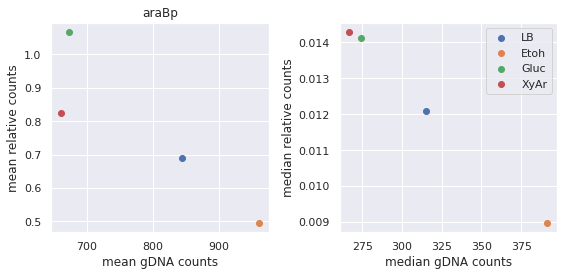

In [461]:
promoter = "araBp"
rel_expression(promoter)

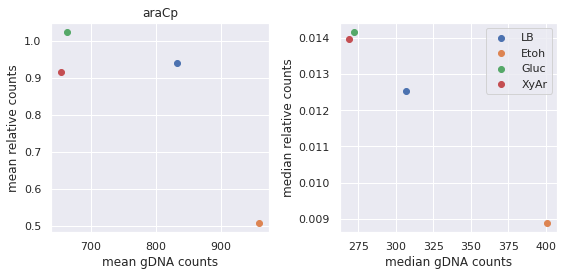

In [462]:
promoter = "araCp"
rel_expression(promoter)

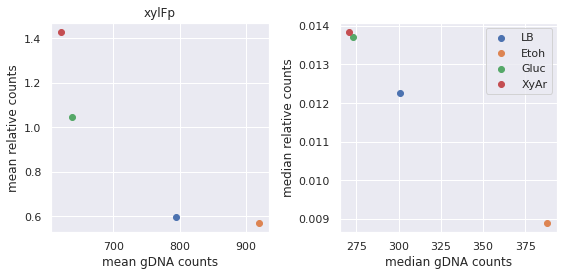

In [463]:
promoter = "xylFp"
rel_expression(promoter)

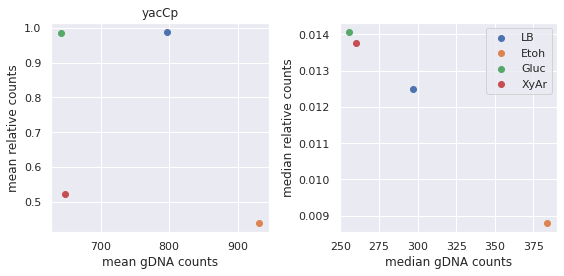

In [464]:
promoter = "yacCp"
rel_expression(promoter)

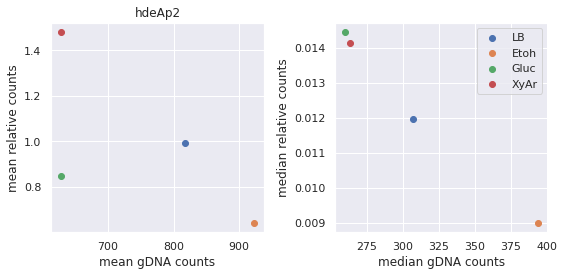

In [465]:
promoter = find_promoter("hdeA")
rel_expression(promoter)

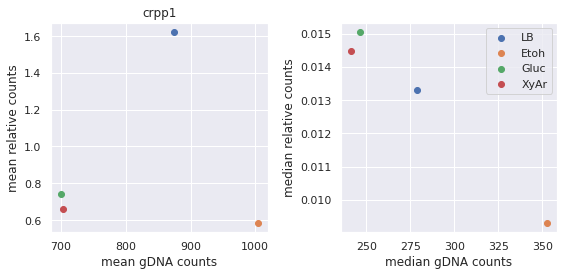

In [466]:
promoter = find_promoter("crp")
rel_expression(promoter)

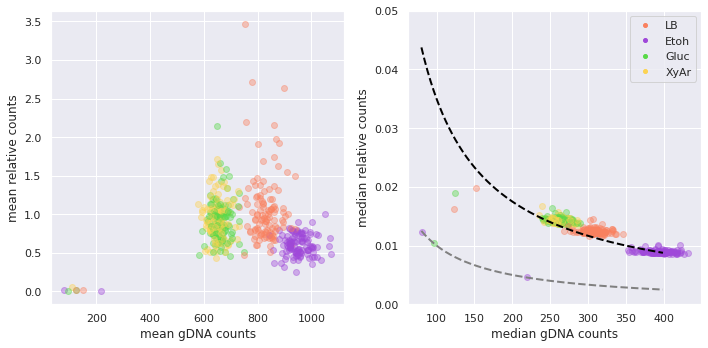

In [476]:
color_dict={
    "LB":"#FA815F",
    "Etoh":"#9F48D9",
    "Gluc":"#58D948",
    "XyAr":"#FCD353"
   }
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].set_xlabel("mean gDNA counts")
ax[0].set_ylabel("mean relative counts")

ax[1].set_xlabel("median gDNA counts")
ax[1].set_ylabel("median relative counts")
for promoter in promoter_names:
    for i, gc in enumerate(["LB", "Etoh", "Gluc", "XyAr"]):
        # Double check that the files for the promoter exist
        filepath = "../../../data/processed_barcodes/20221114_barcode/{}_by_promoter/{}_counts.csv".format(gc, promoter)
        if not exists(filepath):
            break
        df = pd.read_csv(filepath)
        df["relative_counts"] = df.cDNA_count / df.gDNA_count
        df["total_counts"] = df.cDNA_count + df.gDNA_count
        ax[0].scatter(np.mean(df.gDNA_count), np.mean(df["relative_counts"]), color=color_dict[gc], alpha=0.4)
        ax[1].scatter(np.median(df.gDNA_count), np.median(df["relative_counts"]), color=color_dict[gc], alpha=0.4)

custom_lines = [
    Line2D([0], [0], color=color_dict["LB"], marker='o', lw=0, markersize=4),
    Line2D([0], [0], color=color_dict["Etoh"], marker='o', lw=0, markersize=4),
    Line2D([0], [0], color=color_dict["Gluc"], marker='o', lw=0, markersize=4),
    Line2D([0], [0], color=color_dict["XyAr"], marker='o', lw=0, markersize=4)
   ]

ax[1].legend(custom_lines, ["LB", "Etoh", "Gluc", "XyAr"])
ax[1].plot(np.arange(80, 400), 1/np.arange(80, 400), "--", color="gray", lw=2)
ax[1].plot(np.arange(80, 400), 3.5/np.arange(80, 400), "--", color="black", lw=2)
ax[1].set_ylim([0, 0.05])
plt.tight_layout()

# MaveNN